In [1]:
%matplotlib notebook
from matplotlib import pyplot
import numpy
import randomgen

from epsie.proposals import Normal
from epsie.chain import Chain

In [2]:
# simple model for testing
from scipy import stats
class Model(object):
    def __init__(self):
        # we'll use a 2D Gaussian for the likelihood distribution
        self.params = ['x', 'y']
        self.mean = [2., 5.]
        self.cov = [[1., 0.], [0., 2.]]
        self.likelihood_dist = stats.multivariate_normal(mean=self.mean,
                                                         cov=self.cov)

        # we'll just use a uniform prior
        self.prior_bounds = {'x': (-20., 20.),
                             'y': (-20., 20.)}
        xmin = self.prior_bounds['x'][0]
        dx = self.prior_bounds['x'][1] - xmin
        ymin = self.prior_bounds['y'][0]
        dy = self.prior_bounds['y'][1] - ymin
        self.prior_dist = {'x': stats.uniform(xmin, dx),
                           'y': stats.uniform(ymin, dy)}

    def prior_rvs(self, size=None):
        return {p: self.prior_dist[p].rvs(size=size)
                for p in self.params}
    
    def logprior(self, **kwargs):
        return sum([self.prior_dist[p].logpdf(kwargs[p]) for p in self.params])
    
    def loglikelihood(self, **kwargs):
        return self.likelihood_dist.logpdf([kwargs[p] for p in self.params])
    
    def __call__(self, **kwargs):
        logp = self.logprior(**kwargs)
        if logp == -numpy.inf:
            logl = None
        else:
            logl = self.loglikelihood(**kwargs)
        return logl, logp

In [3]:
model = Model()

In [4]:
# just use a normal distribution for the proposals (Metropolish-Hastings algorithm)
proposal = Normal(['x', 'y'])
# create the chain; we'll use a seed to make the results deterministic
chain = Chain(model.params, model, [proposal], brng=100)

In [5]:
# set the starting positions
chain.set_start(model.prior_rvs())

In [6]:
# evolve the chain for 1000 steps
for _ in range(1000):
    chain.step()

<IPython.core.display.Javascript object>


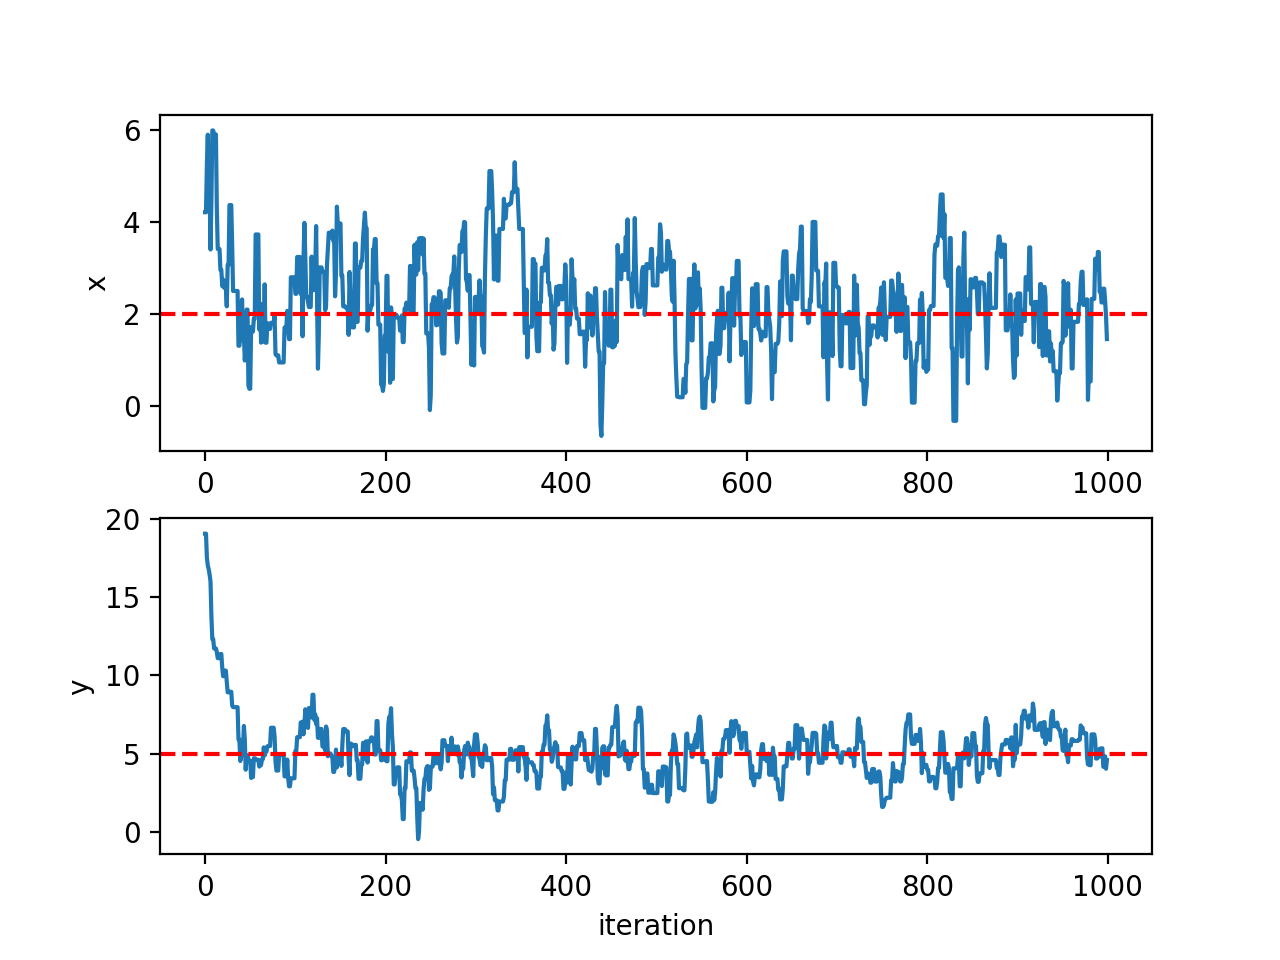

In [7]:
# plot the samples
fig, (ax1, ax2) = pyplot.subplots(2)
ax1.plot(chain.positions['x'])
ax2.plot(chain.positions['y'])
# the true values
ax1.axhline(model.mean[0], color='r', ls='--')
ax2.axhline(model.mean[1], color='r', ls='--')
ax1.set_ylabel('x')
ax2.set_ylabel('y')
ax2.set_xlabel('iteration')
fig.show()

<IPython.core.display.Javascript object>


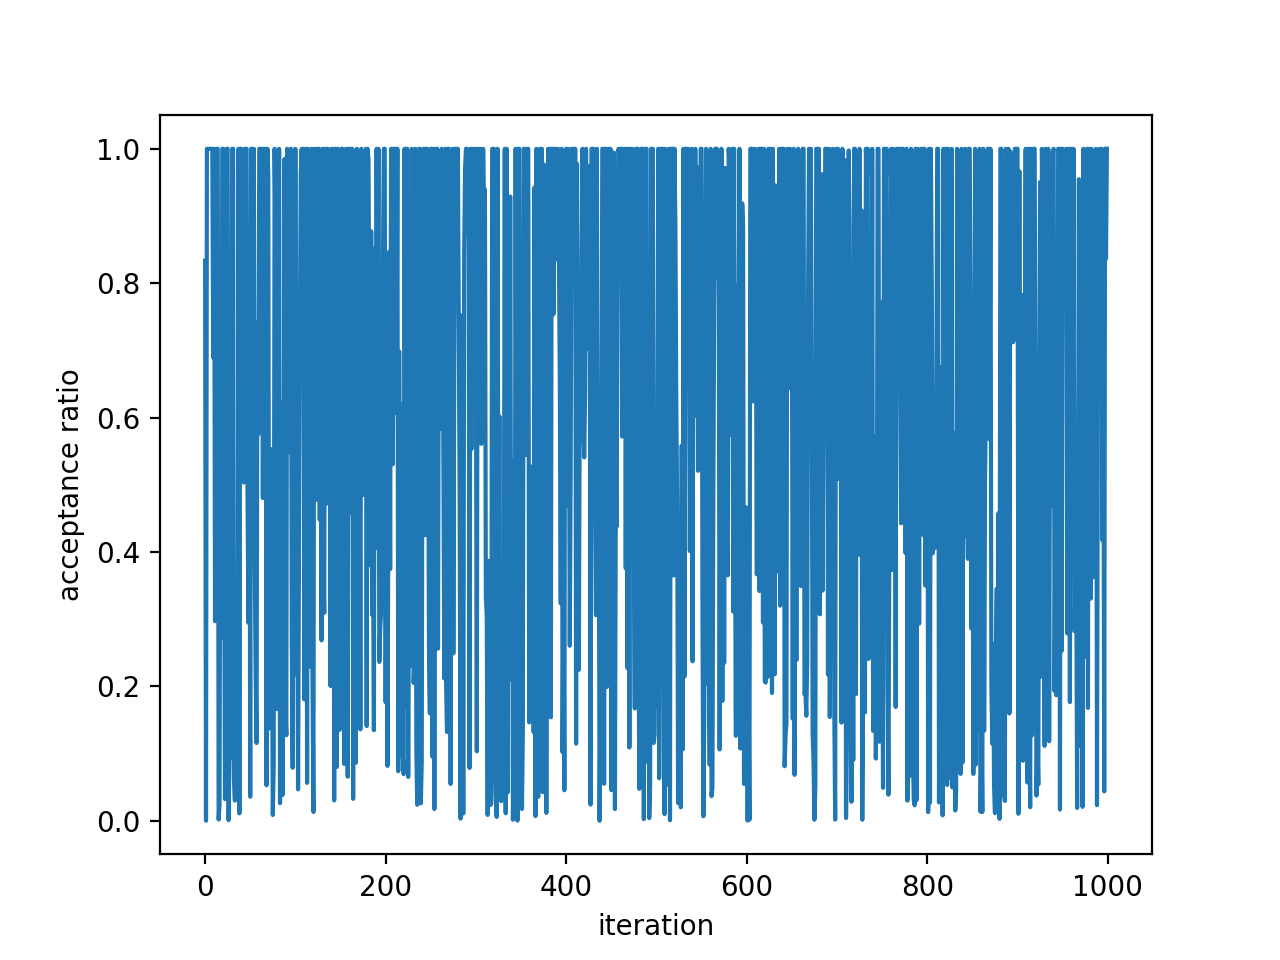

In [8]:
# plot the acceptance ratios (clipped off at 1)
fig, ax = pyplot.subplots()
ar = chain.acceptance_ratios.copy()
ar[ar > 1.] = 1.
ax.plot(ar)
ax.set_xlabel('iteration')
ax.set_ylabel('acceptance ratio')
fig.show()

<IPython.core.display.Javascript object>


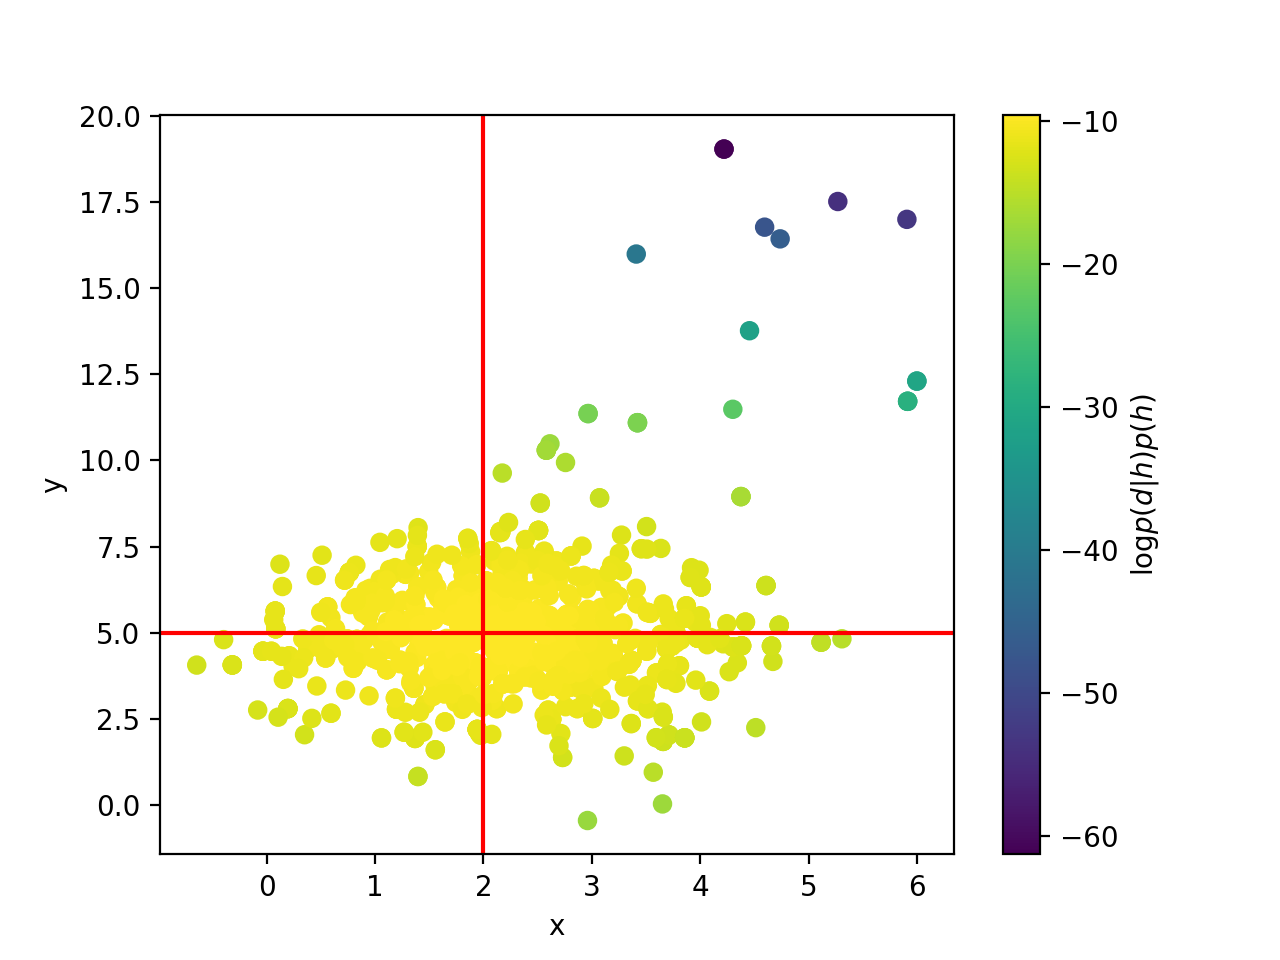

In [9]:
# plot the positions, colored by their log posterior
fig, ax = pyplot.subplots()
s = ax.scatter(chain.positions['x'], chain.positions['y'], c=chain.stats['logl']+chain.stats['logp'])
c = fig.colorbar(s)
# the true values
ax.axvline(model.mean[0], color='r')
ax.axhline(model.mean[1], color='r')
ax.set_xlabel('x')
ax.set_ylabel('y')
c.set_label('$\log p(d|h)p(h)$')
fig.show()